In [59]:
# dependency 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import ipywidgets

# read the csv as df and add the new columns where county names without 'city' and 'county' is placed
df = pd.read_csv('DATA/main_cleaned.csv')
df.head()

,Unnamed: 0,Provider Id,Provider City,Provider Street Address,Provider State,Provider name,Hospital Ownership,Hospital overall rating,Average Total Payments,Average Medicare Payments,BEDS,Cost
0,0,10001,DOTHAN,1108 ROSS CLARK CIRCLE,AL,SOUTHEAST ALABAMA MEDICAL CENTER,Government,3,5777.24,4763.73,420.0,1013.51
1,92,10001,DOTHAN,1108 ROSS CLARK CIRCLE,AL,SOUTHEAST ALABAMA MEDICAL CENTER,Government,3,4894.76,3865.50,420.0,1029.26
2,184,10001,DOTHAN,1108 ROSS CLARK CIRCLE,AL,SOUTHEAST ALABAMA MEDICAL CENTER,Government,3,10260.21,9167.08,420.0,1093.13
3,276,10001,DOTHAN,1108 ROSS CLARK CIRCLE,AL,SOUTHEAST ALABAMA MEDICAL CENTER,Government,3,6542.08,5438.50,420.0,1103.58
4,368,10001,DOTHAN,1108 ROSS CLARK CIRCLE,AL,SOUTHEAST ALABAMA MEDICAL CENTER,Government,3,4596.39,3618.93,420.0,977.46


In [60]:
# states = df.groupby('Provider State').mean().sort_values(by=['Cost'], ascending=False).index
# sns.barplot(x='Provider State', y='Cost', data=df, order=states)
# sns.set(rc={'figure.figsize':(100,150)}, font_scale=7)
# plt.savefig('state_cost.png')
# plt.show()

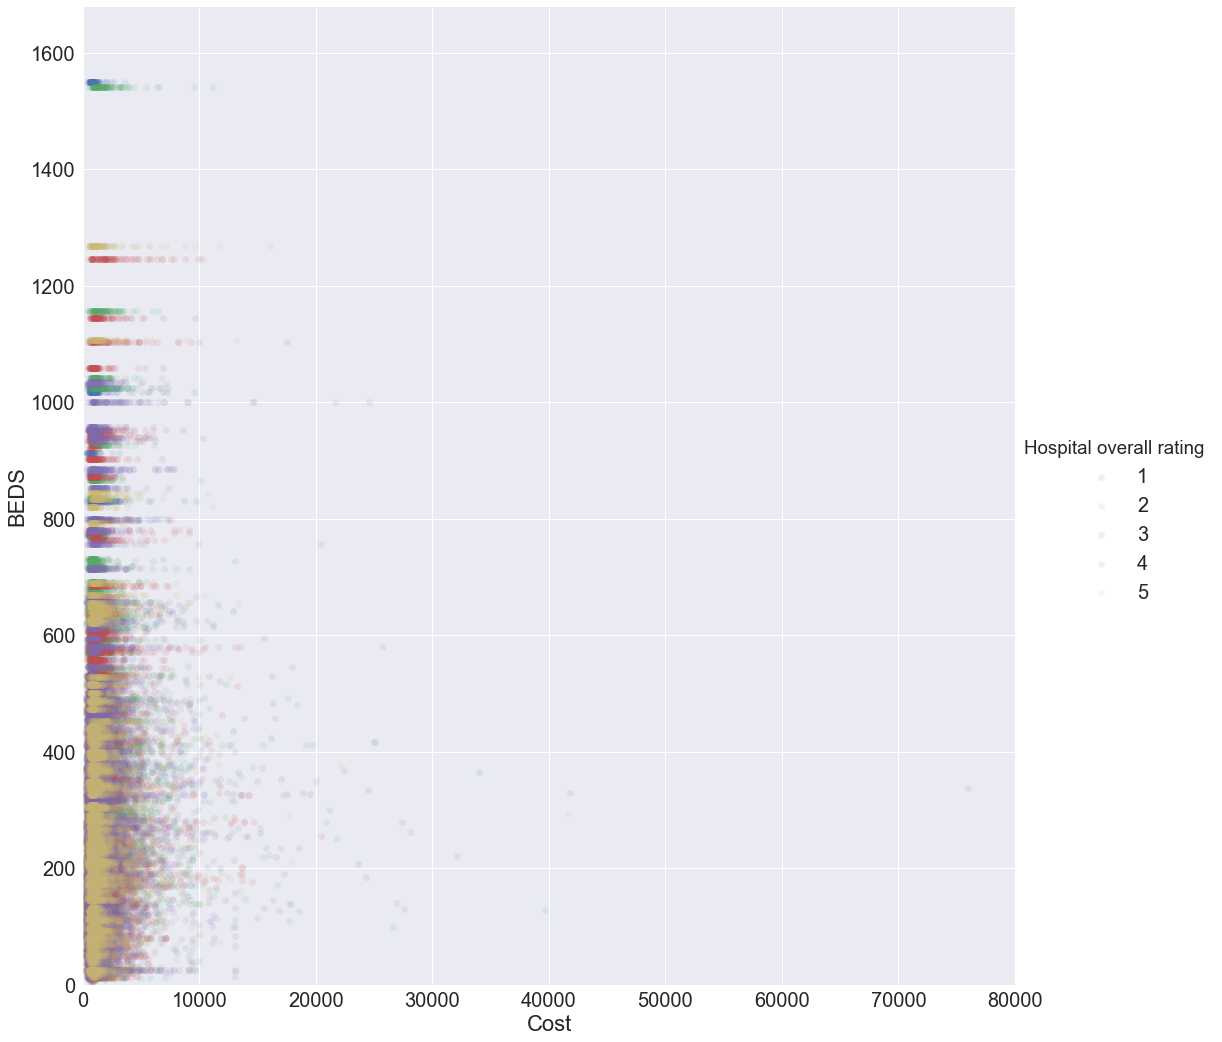

In [61]:
sns.lmplot(x='Cost', y="BEDS", hue="Hospital overall rating", data=df, fit_reg=False, legend=True, size = 15, scatter_kws={'alpha':0.1})
plt.ylim(0,)
plt.xlim(0,)
# plt.savefig('income_charge.png')
plt.show()

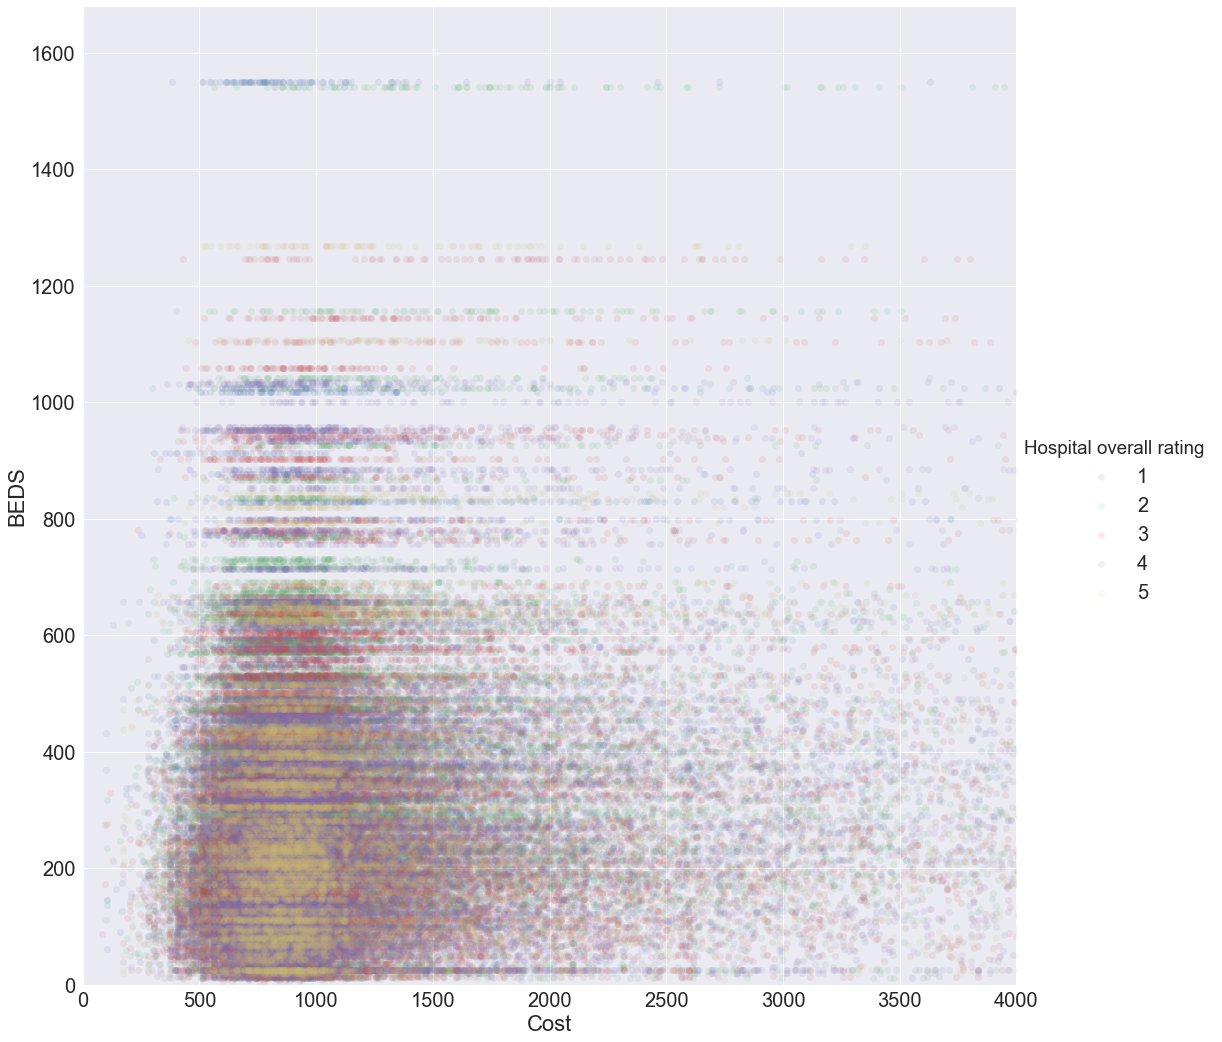

In [62]:
sns.lmplot(x='Cost', y="BEDS", hue="Hospital overall rating", data=df, fit_reg=False, legend=True, size = 15, scatter_kws={'alpha':0.1})
plt.ylim(0,)
plt.xlim(0,4000)
# plt.savefig('income_charge.png')
plt.show()

In [63]:
def showPlot(df, state, rating=[1,2,3,4,5]):
    if not 'Cost' in df.columns:
        print('dataframe must include "Cost" columns. Please check your dataframe!')
    elif not 'Hospital overall rating' in df.columns:
        print('dataframe must include "Hospital overall rating" columns. Please check your dataframe!')
    elif not 'Provider State':
        print('dataframe must include "Provider State" columns. Please check your dataframe!')
    elif not state in list(df['Provider State']):
        print('your state input might be wrong. please check your input!')
    elif not isinstance(rating, list) or len(rating)==0:
        print('rating must be a list contains more than one numeric element. please check your input!')
    else:
        dfbyState = df[df['Provider State'] == state]
        dfbyState_Rating = dfbyState[dfbyState["Hospital overall rating"].isin(rating)]
        sns.lmplot(x='Cost', y="BEDS", hue="Hospital overall rating", data=dfbyState_Rating, fit_reg=False, legend=True, size = 15, scatter_kws={'alpha':0.3})
        sns.set(font_scale=2)
        plt.ylim(0,)
        plt.xlim(0,4000)
        plt.title(f'Cost-Size relationship in {state}')
#         plt.savefig(f'cost_size_rating_in{state}.png')
        plt.show()

In [64]:
def f(STATE):
    showPlot(df,STATE)
states = df.groupby('Provider State').mean().index
ipywidgets.interact(f, STATE=states);
# ipywidgets.interact(lambda state, rating: showPlot(df, state,rating))

A Jupyter Widget